# Imports

In [832]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import mpl_bsic

# Load Data

### S&P 500, Risk Free Rate and Indicators

In [513]:
# Risk Free Rate
rf_rate = pd.read_csv('data/rf_data.csv', index_col=0, parse_dates=True)

In [499]:
# S&P 500 data
sp500_data = pd.read_csv('data/s&p500_data.csv', index_col = 0, parse_dates=True)
sp500_data['Daily Returns'] = sp500_data['Close'].pct_change()

In [500]:
indicators = pd.read_csv('data/indicators.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
indicators_w_polyterns = pd.read_csv('data/indicators_w_polyterms.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
Y_Matrix = pd.read_csv('data/Y_Matrix.csv', index_col=0, parse_dates=True)

### Logistic Regression

In [730]:
log_reg_results = pd.read_pickle('models/log_reg_results.pkl')
log_reg_results_07 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_0.7.pkl')
log_reg_results_08 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_0.8.pkl')
log_reg_results_09 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_0.9.pkl')
log_reg_results_11 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_1.1.pkl')
log_reg_results_12 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_1.2.pkl')
log_reg_results_13 = pd.read_pickle('models/log_reg_results_constant/log_reg_results_1.3.pkl')

### Random Forest

In [747]:
rf_results = pd.read_pickle('models/rf_results.pkl')
rf_results_07 = pd.read_pickle('models/rf_results_constant/rf_results_0.7.pkl')
rf_results_08 = pd.read_pickle('models/rf_results_constant/rf_results_0.8.pkl')
rf_results_09 = pd.read_pickle('models/rf_results_constant/rf_results_0.9.pkl')
rf_results_11 = pd.read_pickle('models/rf_results_constant/rf_results_1.1.pkl')
rf_results_12 = pd.read_pickle('models/rf_results_constant/rf_results_1.2.pkl')
rf_results_13 = pd.read_pickle('models/rf_results_constant/rf_results_1.3.pkl')

### XG Boost

In [818]:
xgb_results = pd.read_pickle('models/xgb_results.pkl')
xgb_results_07 = pd.read_pickle('models/xgb_results_constant/xgb_results_0.7.pkl')
xgb_results_08 = pd.read_pickle('models/xgb_results_constant/xgb_results_0.8.pkl')
xgb_results_09 = pd.read_pickle('models/xgb_results_constant/xgb_results_0.9.pkl')
xgb_results_11 = pd.read_pickle('models/xgb_results_constant/xgb_results_1.1.pkl')
xgb_results_12 = pd.read_pickle('models/xgb_results_constant/xgb_results_1.2.pkl')
xgb_results_13 = pd.read_pickle('models/xgb_results_constant/xgb_results_1.3.pkl')

### SVM

In [ ]:
svm_results = pd.read_pickle('models/svm_results.pkl')

# Apply Models

In [501]:
def fit_models(indicators, params):
    """
    Fits multiple models to given indicators and returns a DataFrame of predicted probabilities.

    Parameters:
    indicators : pd.DataFrame
        A DataFrame containing indicator values indexed by year.
    params : dict
        A dictionary where keys represent different model types and values are lists of models
        corresponding to different years.

    Returns:
    pd.DataFrame
        A DataFrame containing predicted probabilities for all models and types.
    """

    final = []  # List to store final results across all strategies

    # Iterate over each model type and its corresponding models for different years
    for type, tenure in tqdm(params.items()):  # tqdm adds a progress bar for long loops
        per_strategy = []  # Store results for this particular strategy/model type

        # Loop over the models corresponding to different years
        for i in range(len(tenure)):
            model = tenure[i]  # Select the model for year i
            current_year = str(2000 + i)  # Convert index position to a year string (assuming year 2000 is the base)

            # Extract indicators for the current year
            current_indicators = indicators.loc[current_year]

            # Compute predicted probabilities using the model
            probabilities = model.predict_proba(current_indicators)

            # Store only the probability of the positive class (column index 1)
            per_strategy.append(
                pd.DataFrame(probabilities[:, 1],  # Take the second column (probability of positive class)
                             index=current_indicators.index,  # Keep the same index as input indicators
                             columns=[f'{type}'])  # Name the column after the model type
            )

        # Concatenate results for the current strategy/model type along the rows (time axis)
        final.append(pd.concat(per_strategy, axis=0))

    # Concatenate all model types along the columns (different strategies)
    return pd.concat(final, axis=1)

### Logistic Regression

In [732]:
prob_log_reg = fit_models(indicators_w_polyterns, log_reg_results)
prob_log_reg_07 = fit_models(indicators_w_polyterns, log_reg_results_07)
prob_log_reg_08 = fit_models(indicators_w_polyterns, log_reg_results_08)
prob_log_reg_09 = fit_models(indicators_w_polyterns, log_reg_results_09)
prob_log_reg_11 = fit_models(indicators_w_polyterns, log_reg_results_11)
prob_log_reg_12 = fit_models(indicators_w_polyterns, log_reg_results_12)
prob_log_reg_13 = fit_models(indicators_w_polyterns, log_reg_results_13)

100%|██████████| 8/8 [00:00<00:00, 17.20it/s]


### Random Forest

In [748]:
prob_rf = fit_models(indicators, rf_results)
prob_rf_07 = fit_models(indicators, rf_results_07)
prob_rf_08 = fit_models(indicators, rf_results_08)
prob_rf_09 = fit_models(indicators, rf_results_09)
prob_rf_11 = fit_models(indicators, rf_results_11)
prob_rf_12 = fit_models(indicators, rf_results_12)
prob_rf_13 = fit_models(indicators, rf_results_13)

100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


### XG Boost

In [821]:
prob_xgb = fit_models(indicators, xgb_results)
prob_xgb_07 = fit_models(indicators, xgb_results_07)
prob_xgb_08 = fit_models(indicators, xgb_results_08)
prob_xgb_09 = fit_models(indicators, xgb_results_09)
prob_xgb_11 = fit_models(indicators, xgb_results_11)
prob_xgb_12 = fit_models(indicators, xgb_results_12)
prob_xgb_13 = fit_models(indicators, xgb_results_13)

100%|██████████| 8/8 [00:00<00:00, 27.06it/s]


### SVM

In [ ]:
prob_svm = fit_models(indicators, svm_results)

# Rescale Position from Probabilities

In [947]:
def compute_position(probabilities):
    position = probabilities.applymap(
      lambda x: 1 if x > 0.3 else 0)
    return position.shift(1).dropna()

### Logiatic Regression

In [948]:
position_log_reg = compute_position(prob_log_reg)
position_log_reg_07 = compute_position(prob_log_reg_07)
position_log_reg_08 = compute_position(prob_log_reg_08)
position_log_reg_09 = compute_position(prob_log_reg_09)
position_log_reg_11 = compute_position(prob_log_reg_11)
position_log_reg_12 = compute_position(prob_log_reg_12)
position_log_reg_13 = compute_position(prob_log_reg_13)

### Random Forest

In [807]:
position_rf = compute_position(prob_rf)
position_rf_07 = compute_position(prob_rf_07)
position_rf_08 = compute_position(prob_rf_08)
position_rf_09 = compute_position(prob_rf_09)
position_rf_11 = compute_position(prob_rf_11)
position_rf_12 = compute_position(prob_rf_12)
position_rf_13 = compute_position(prob_rf_13)

### XG Boost

In [822]:
position_xgb = compute_position(prob_xgb)
position_xgb_07 = compute_position(prob_xgb_07)
position_xgb_08 = compute_position(prob_xgb_08)
position_xgb_09 = compute_position(prob_xgb_09)
position_xgb_11 = compute_position(prob_xgb_11)
position_xgb_12 = compute_position(prob_xgb_12)
position_xgb_13 = compute_position(prob_xgb_13)

### SVM

In [ ]:
position_svm = compute_position(prob_svm)

# Backtest Strategy

In [959]:
def backtest_strategy(position, asset, rf_data, tc=0.0005):
    """
    Backtests a trading strategy based on given position signals and asset data.

    Parameters:
    - position : pd.DataFrame
        A DataFrame containing trading positions (long/short) indexed by date.
    - asset : pd.DataFrame
        A DataFrame containing asset price and return data (must include 'Daily Returns').
    - rf_data : pd.DataFrame
        A DataFrame containing risk-free rate data (must include 'Close' for the interest rate).
    - tc : float, optional (default=0.0005)
        The transaction cost per unit of position change.

    Returns:
    - pd.DataFrame
        A DataFrame containing backtested strategy returns for different time horizons.
    """

    total_returns = pd.DataFrame(index=position.index)  # Initialize an empty DataFrame to store results

    # Loop over different time horizons for strategy evaluation
    for n in (3, 5, 8, 10):
        # Filter position data for the current time horizon (e.g., '3 days', '5 days', etc.)
        # Resample to business days, take the first value of each period, and forward-fill missing values
        current_position = (
            position.filter(like=f'{n} days')
            .resample(f'{n}B').first()  # Resample to business days and take the first position
            .reindex(asset.index)  # Ensure index aligns with asset data
            .ffill()  # Forward-fill missing values
            .dropna()  # Remove remaining NaN values
        )

        # Determine the actual trading position:
        # If the long position is greater than or equal to the absolute value of the short position,
        # take the long position; otherwise, take the short position.
        current_position[f'pos {n} days'] = np.where(
            current_position[f'long {n} days'] >= abs(current_position[f'short {n} days']),
            current_position[f'long {n} days'],
            0
        )

        # Calculate the risk-free position: the remaining fraction of capital not allocated to the asset
        current_position['risk free pos'] = 1 - np.abs(current_position[f'pos {n} days'])

        # Compute changes in position (to account for transaction costs)
        current_position['change in pos'] = np.abs(current_position[f'pos {n} days'].diff().fillna(0))

        # Align asset returns and risk-free rate data to match the index of `current_position`
        aligned_asset_returns = asset['Daily Returns'].reindex(current_position.index)
        aligned_rf_data = rf_data['Close'].reindex(current_position.index)

        # Compute returns:
        # - The asset return is weighted by the position size.
        # - The risk-free return is adjusted for daily compounding.
        # - Transaction costs are deducted based on position changes.
        returns = (
            current_position[f'pos {n} days'] * aligned_asset_returns.values +  # Asset returns
            current_position['risk free pos'] * (aligned_rf_data.values / 365 / 100) -  # Daily risk-free rate
            tc * current_position['change in pos']  # Transaction cost based on position changes
        )

        # Convert the returns into a DataFrame with an appropriate column name
        returns_df = pd.DataFrame(returns, index=current_position.index, columns=[f'returns {n} days'])

        # Merge the computed returns with the total_returns DataFrame
        total_returns = pd.merge(total_returns, returns_df, left_index=True, right_index=True, how='outer')

    return total_returns

### Logistic Regression

In [960]:
returns_log_reg = backtest_strategy(position_log_reg, sp500_data, rf_rate)
returns_log_reg_07 = backtest_strategy(position_log_reg_07, sp500_data, rf_rate)
returns_log_reg_08 = backtest_strategy(position_log_reg_08, sp500_data, rf_rate)
returns_log_reg_09 = backtest_strategy(position_log_reg_09, sp500_data, rf_rate)
returns_log_reg_11 = backtest_strategy(position_log_reg_11, sp500_data, rf_rate)
returns_log_reg_12 = backtest_strategy(position_log_reg_12, sp500_data, rf_rate)
returns_log_reg_13 = backtest_strategy(position_log_reg_13, sp500_data, rf_rate)

In [961]:
cum_returns_log_reg = (1 + returns_log_reg).cumprod(axis = 0) - 1
cum_returns_log_reg_07 = (1 + returns_log_reg_07).cumprod(axis = 0) - 1
cum_returns_log_reg_08 = (1 + returns_log_reg_08).cumprod(axis = 0) - 1
cum_returns_log_reg_09 = (1 + returns_log_reg_09).cumprod(axis = 0) - 1
cum_returns_log_reg_11 = (1 + returns_log_reg_11).cumprod(axis = 0) - 1
cum_returns_log_reg_12 = (1 + returns_log_reg_12).cumprod(axis = 0) - 1
cum_returns_log_reg_13 = (1 + returns_log_reg_13).cumprod(axis = 0) - 1

### Random Forest

In [962]:
returns_rf = backtest_strategy(position_rf, sp500_data, rf_rate)
returns_rf_07 = backtest_strategy(position_rf_07, sp500_data, rf_rate)
returns_rf_08 = backtest_strategy(position_rf_08, sp500_data, rf_rate)
returns_rf_09 = backtest_strategy(position_rf_09, sp500_data, rf_rate)
returns_rf_11 = backtest_strategy(position_rf_11, sp500_data, rf_rate)
returns_rf_12 = backtest_strategy(position_rf_12, sp500_data, rf_rate)
returns_rf_13 = backtest_strategy(position_rf_13, sp500_data, rf_rate)

In [963]:
cum_returns_rf = (1 + returns_rf).cumprod(axis = 0) - 1
cum_returns_rf_07 = (1 + returns_rf_07).cumprod(axis = 0) - 1
cum_returns_rf_08 = (1 + returns_rf_08).cumprod(axis = 0) - 1
cum_returns_rf_09 = (1 + returns_rf_09).cumprod(axis = 0) - 1
cum_returns_rf_11 = (1 + returns_rf_11).cumprod(axis = 0) - 1
cum_returns_rf_12 = (1 + returns_rf_12).cumprod(axis = 0) - 1
cum_returns_rf_13 = (1 + returns_rf_13).cumprod(axis = 0) - 1

### XG Boost

In [964]:
returns_xgb = backtest_strategy(position_xgb, sp500_data, rf_rate)
returns_xgb_07 = backtest_strategy(position_xgb_07, sp500_data, rf_rate)
returns_xgb_08 = backtest_strategy(position_xgb_08, sp500_data, rf_rate)
returns_xgb_09 = backtest_strategy(position_xgb_09, sp500_data, rf_rate)
returns_xgb_11 = backtest_strategy(position_xgb_11, sp500_data, rf_rate)
returns_xgb_12 = backtest_strategy(position_xgb_12, sp500_data, rf_rate)
returns_xgb_13 = backtest_strategy(position_xgb_13, sp500_data, rf_rate)

In [965]:
cum_returns_xgb = (1 + returns_xgb).cumprod(axis = 0) - 1
cum_returns_xgb_07 = (1 + returns_xgb_07).cumprod(axis = 0) - 1
cum_returns_xgb_08 = (1 + returns_xgb_08).cumprod(axis = 0) - 1
cum_returns_xgb_09 = (1 + returns_xgb_09).cumprod(axis = 0) - 1
cum_returns_xgb_11 = (1 + returns_xgb_11).cumprod(axis = 0) - 1
cum_returns_xgb_12 = (1 + returns_xgb_12).cumprod(axis = 0) - 1
cum_returns_xgb_13 = (1 + returns_xgb_13).cumprod(axis = 0) - 1

### SVM

In [966]:
returns_svm = backtest_strategy(position_svm, sp500_data, rf_rate)

In [967]:
cum_returns_svm = ( 1 + returns_svm).cumprod(axis = 0) - 1

# Plots

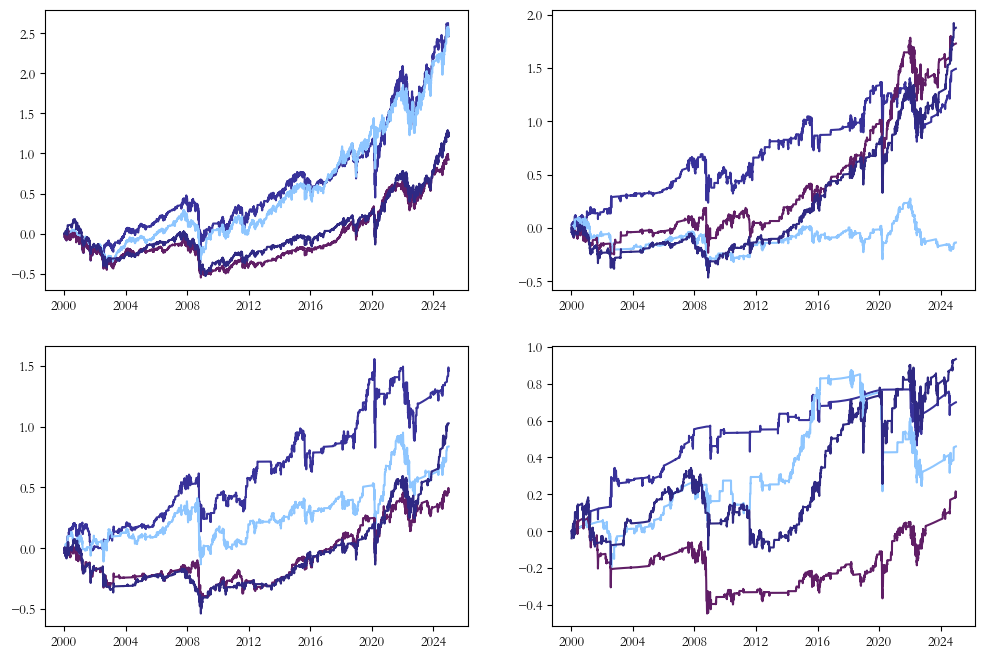

In [968]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_log_reg)
ax[0, 1].plot(cum_returns_rf)
ax[1, 0].plot(cum_returns_xgb)
ax[1, 1].plot(cum_returns_svm)

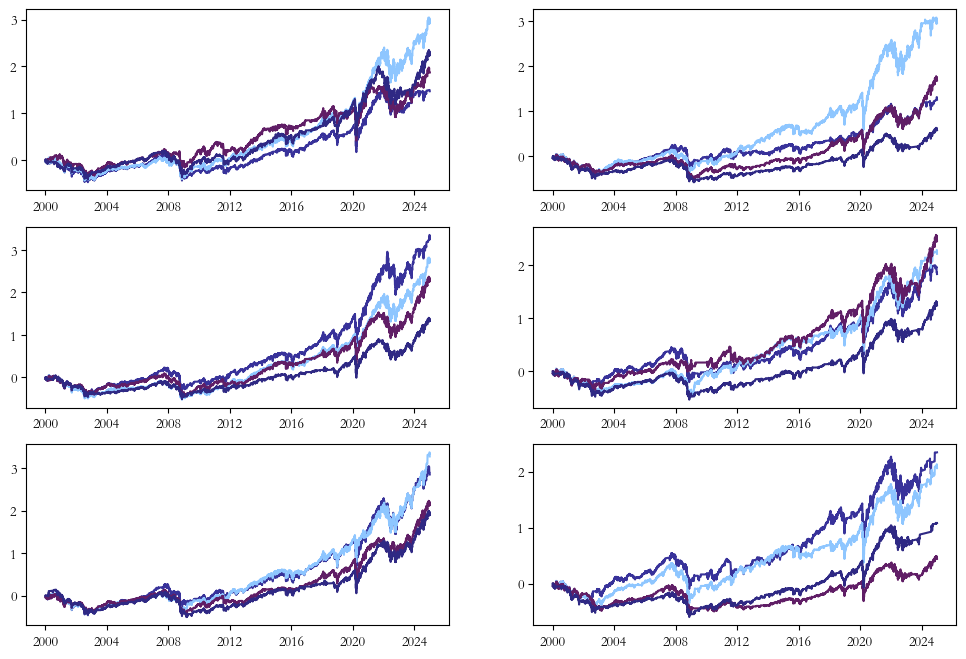

In [969]:
fig, ax = plt.subplots(3, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_log_reg_07)
ax[1, 0].plot(cum_returns_log_reg_08)
ax[2, 0].plot(cum_returns_log_reg_09)
ax[0, 1].plot(cum_returns_log_reg_11)
ax[1, 1].plot(cum_returns_log_reg_12)
ax[2, 1].plot(cum_returns_log_reg_13)

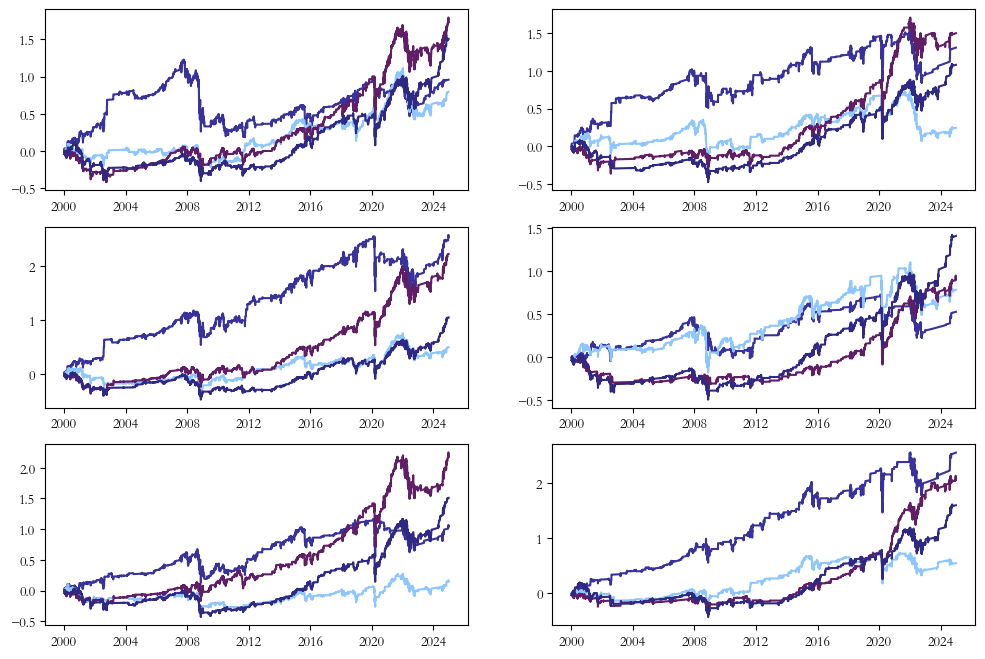

In [970]:
fig, ax = plt.subplots(3, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_rf_07)
ax[1, 0].plot(cum_returns_rf_08)
ax[2, 0].plot(cum_returns_rf_09)
ax[0, 1].plot(cum_returns_rf_11)
ax[1, 1].plot(cum_returns_rf_12)
ax[2,1].plot(cum_returns_rf_13)

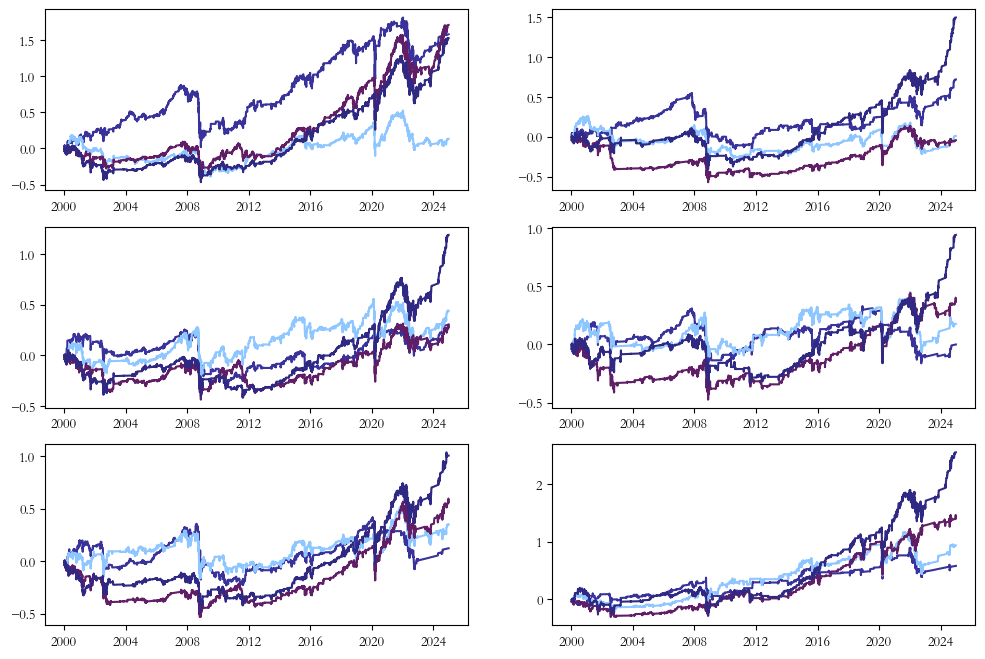

In [971]:
fig, ax = plt.subplots(3, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_xgb_07)
ax[1, 0].plot(cum_returns_xgb_08)
ax[2, 0].plot(cum_returns_xgb_09)
ax[0, 1].plot(cum_returns_xgb_11)
ax[1, 1].plot(cum_returns_xgb_12)
ax[2, 1].plot(cum_returns_xgb_13)

# Rolling Sharpe

In [972]:
def rolling_sharpe(strategy_returns, rfr):
    sharpe = pd.DataFrame(index = strategy_returns.index)
    sharpe['strategy_ret'] = strategy_returns.values
    sharpe['rfr'] = rfr.reindex(strategy_returns.index).values / 365 / 100
    sharpe = sharpe.dropna()
    sharpe['rolling sharpe'] = (sharpe['strategy_ret'].rolling(252).mean() - sharpe['rfr'].rolling(252).mean())/ sharpe['strategy_ret'].rolling(252).std() * np.sqrt(252)
    return sharpe

In [973]:
x = rolling_sharpe(returns_log_reg_07['returns 10 days'], rf_rate)
z = rolling_sharpe(returns_log_reg_08['returns 10 days'], rf_rate)
y = rolling_sharpe(returns_log_reg_09['returns 10 days'], rf_rate)
w = rolling_sharpe(returns_log_reg_11['returns 10 days'], rf_rate)
d = rolling_sharpe(returns_log_reg_12['returns 10 days'], rf_rate)
s = rolling_sharpe(returns_log_reg_13['returns 10 days'], rf_rate)
t = rolling_sharpe(returns_log_reg['returns 10 days'], rf_rate)

In [974]:
sp_sharpe = rolling_sharpe(sp500_data['Daily Returns'].reindex(returns_log_reg.index), rf_rate)

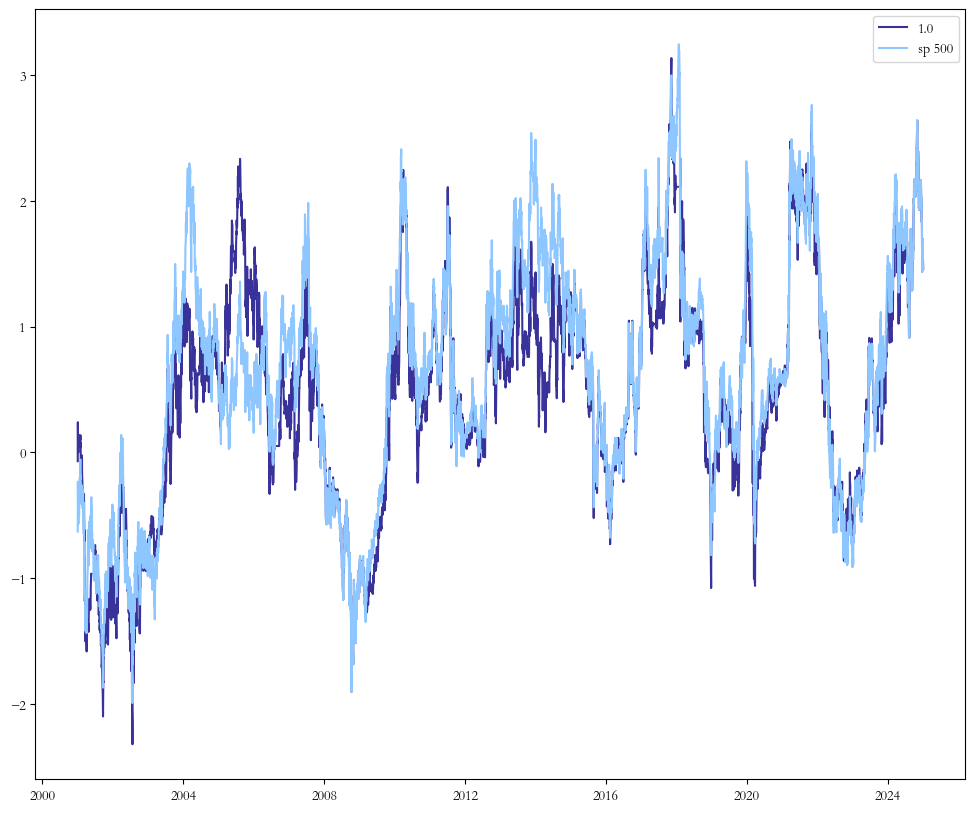

In [975]:
_, ax = plt.subplots(figsize = (12, 10))
ax.set_facecolor('white')
#x['rolling sharpe'].plot(label = '0.7')
#z['rolling sharpe'].plot(label = '0.8')
ax.plot(t['rolling sharpe'], label = '1.0')
#y['rolling sharpe'].plot(label = '0.9')
#w['rolling sharpe'].plot(label = '1.1')
#d['rolling sharpe'].plot(label = '1.2')
#s['rolling sharpe'].plot(label = '1.3')

ax.plot(sp_sharpe['rolling sharpe'], label = 'sp 500')
plt.legend()

In [957]:
x.mean()

strategy_ret      0.000246
rfr               0.000049
rolling sharpe    0.564916
dtype: float64

In [958]:
sp_sharpe.mean()

strategy_ret      0.000299
rfr               0.000049
rolling sharpe    0.603924
dtype: float64